<a href="https://colab.research.google.com/github/wilburshi/LogisticRegression_tutorial/blob/main/LogisticRegression_JuiceChoice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression for Two-Option Juice Choice Task

Many decision tasks require the subjects to choose between two options. Here, we show how to use logistic regression to analyze the choice pattern when subjects choose between two juice options with variable quantities, and the two options are presented as the same time. The example data is from non-human primate (rhesus monkeys) studies. 

Juice Choice Task


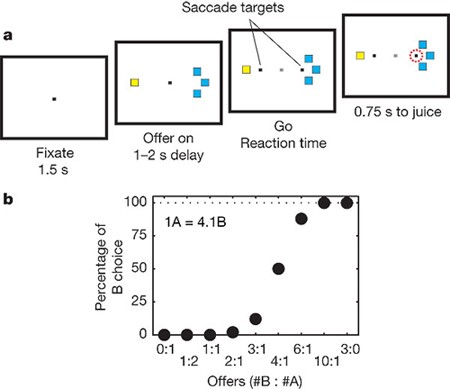

In [ ]:
from IPython.display import Image, display
print('Juice Choice Task')
display(Image('../pics/JC_tasks.jpg', width=400, unconfined=True))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

## Step 1: load data

First, let's load example data file named as `goodTrials_JC.mat`. It only contains trials that monkey has successfully chosen one of the juice option.  

`goodTrials_JC.mat` is a $N \times 4$, where $N$ is the number of the trials in this session, and in this example, $N =176$. The columns of this matrix indicated:

 - *column 1*: the trial number.

 - *column 2*: the quantity of juice A. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 3*: the quantity of juice B. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 4*: the chosen juice type, with 1 indicating A and 2 indicating B.


In [ ]:
# !git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
# data = loadmat('LogisticRegression_tutorial/data/goodtrials_JC.mat')['goodTrials_JC'] # use it only for goole colab
data = loadmat('../data/goodtrials_JC.mat')['goodTrials_JC'] # loadmat is a function in scipy.io used to load Matlab data file

# Independent variables
QA = np.abs(data[:,1]) # quantity of juice A
QB = np.abs(data[:,2]) # quantity of juice B
SideA = np.sign(data[:,1]) # side of target A. -1: left, 1: right, 0 forced choice

# Dependent variables
CJ = data[:,3]-1 # the type of chosen juice. 0: chosen A, 1: chosen B

ind_forced = (data[:,1] == 0) | (data[:,2] == 0) # index of forced choice
ind_nonforced = ~ind_forced

## Step 2: probit regression fitting
we used probit regression to fit the choice pattern. the model was as follows:

$ choice B = \Phi(X) $

$ X = a_0 + a_1 log(q_B/q_A) $

where $choice B = 1$ if juice B is chosen and 0 otherwise. $\Phi$ is the cumulative function of a Gaussian distribution (probit link). $q_A$ and $q_B$ are the juice quantity for A and B in each trial. $a_0$ and $a_1$ are the fitted parameters, from which we define the relative value ($\rho$) between A and B as $\rho = exp(-a_0/a_1)$ and the sigmoid steepness ($\eta$) as $\eta = a_1$. Relative value measures the indifference point at which the value of A and B are the same, that is, $1 q_A = \rho q_B$; steepness reflects the choice accuracy which is inverse to the choice variability.

In [ ]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit

In [ ]:
# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X = np.log(QB[ind_nonforced]/QA[ind_nonforced])
const = np.ones(X.shape)

# probit regression
model = Probit(Y, np.transpose([const, X]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.285275
         Iterations 8


## Step 3: plotting
We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities). We also exclude the forced choice for convenience.

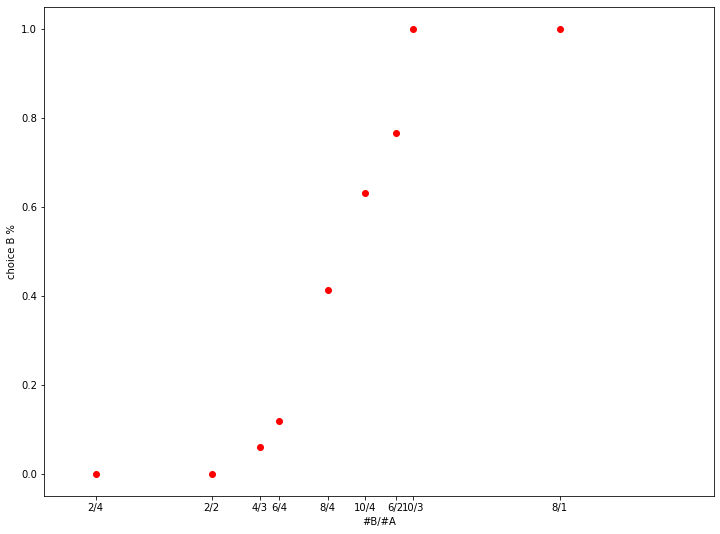

In [ ]:
#####
# plot the results #
#####
# calculate offer types
table01 = np.unique([QB[ind_nonforced], QA[ind_nonforced]], axis = 1) # create offer type table from individual trials
LogRatio = np.log(table01[0,:]/table01[1,:])
ntritype = np.shape(table01)[1]

# calculate the percentage of choice B #
PB = np.array([]) # percentage of choice B
xtickname = np.array([]) # x axis tick names
for itritype in np.arange(0, ntritype,1):
    ind_itritype = (np.transpose([QB, QA]) == np.transpose(table01)[itritype,:]).all(axis=1)
    CJ_itritype = CJ[ind_itritype]
    PB_itritype = np.sum(CJ_itritype)/(np.shape(CJ_itritype)[0])
    PB = np.append(PB,PB_itritype)
    xtickname_itritype = np.array2string(table01[0,itritype])+'/'+np.array2string(table01[1,itritype])
    xtickname = np.append(xtickname,xtickname_itritype)
    
# plot data point - offer types
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio,PB, 'ro')
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio)
ax.set_xticklabels(xtickname); 

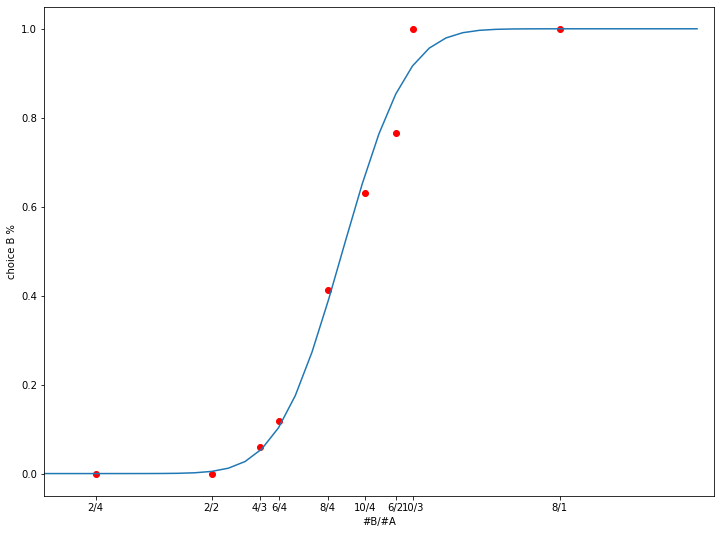

In [ ]:
# plot sigmoidal curve     
X_plot = np.arange(np.floor(np.min(LogRatio)), np.ceil(np.max(LogRatio)), 0.1)
const_plot = np.ones(np.size(X_plot))
Y_plot = probit_model.predict(np.transpose([const_plot, X_plot]))

# plot
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio,PB, 'ro')
plt.plot(X_plot,Y_plot)
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio)
ax.set_xticklabels(xtickname); 

In [ ]:
rho = np.exp(-betas[0]/betas[1])
print('relative value ρ is: ', np.array2string(rho))
eta = betas[1]
print('steepness η is: ', np.array2string(eta))


relative value ρ is:  2.18647539
steepness η is:  3.30671802
